In [8]:
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np

from pprint import pprint
from copy import deepcopy as dc

import pandas as pd 
import wandb
api = wandb.Api()

from pathlib import Path
home = str(Path.home())

# Define the standard plotting colours.
color_names = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan"
]

color_names = color_names * 10

In [2]:
# # Project is specified by <entity/project-name>
# runs = api.runs("andrewwarrington/fivo-aux-beta")

# summary_list, config_list, name_list = [], [], []
# for run in runs: 
#     # .summary contains the output keys/values for metrics like accuracy.
#     #  We call ._json_dict to omit large files 
#     summary_list.append(run.summary._json_dict)

#     # .config contains the hyperparameters.
#     #  We remove special values that start with _.
#     config_list.append(
#         {k: v for k,v in run.config.items()
#           if not k.startswith('_')})

#     # .name is the human-readable name of the run.
#     name_list.append(run.name)

# runs_df = pd.DataFrame({
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#     })

# runs_df.to_csv("project.csv")

# Get individual run.

In [3]:
def get_experiment_from_wandb(project, exp_tag, exp_key=None, exp_val=None):

    print(exp_tag)
    column_names = ''
    
    # Grab all the runs.
    runs = api.runs(project)
    filtered_runs = []
    filtered_histories = []
    for _run in runs: 
        try:
            # if _run.config['group'] == exp_tag:
            if _run.group == exp_tag:
                filtered_runs.append(_run)
                _hist = _run.history(samples=99999999)
                filtered_histories.append(_hist)  # Run with some token large number to grab all the samples.  Can be very slow.
                column_names = _hist.columns
        except:
            pass
    print(len(filtered_runs))
    
    # Throw and error if there were no runs.
    if len(filtered_runs) == 0:
        raise RuntimeError("No experiments found.  Check the exp_tag.")


    # Now re-grab the runs and make sure they all share keys.
    key_runs = api.runs(project)
    keys = []
    for _run in key_runs: 
        try:
            if _run.group == exp_tag:
                keys.append(_run.scan_history().__next__().keys())
        except Exception as err:
            pass

    # print(keys)
    assert all([keys[0] == _k for _k in keys]), 'Keys are not shared.'
    
    # Go and get everything.
    values = []
    lengths = []
    for _hist in filtered_histories:
        _values = []
        for _v in _hist:
            _values.append(_v)
        values.append(_values)
        lengths.append(len(_values))
    min_Length = np.min(lengths)
        
    return values, min_Length, filtered_histories, column_names


In [4]:
# filtered_histories = run.history(samples=99999999)  # Run with some token large number to grab all the samples.  Can be very slow.
# filtered_histories = [_r.scan_history() for _r in filtered_runs]  # Default to using fewer samples.

plot_styles = ['-', '--', ':', '-.'] * 10

# Project is specified by <entity/project-name>
project = "andrewwarrington/fivo-aux-beta"

exp_tag = ['gdm-v3.0.6-fivo-aux-sgr', 'gdm-v3.0.3-fivo-aux', ]
save_tag = 'gdm-v3-0'

# exp_tag = ['debug', ]
# save_tag = 'debug'

filtered_histories = []
column_names = None
for _tag in exp_tag:
    _, _, _filtered_histories, column_names = get_experiment_from_wandb(project, _tag)
    filtered_histories.append(_filtered_histories)

pprint("Keys:")
pprint(list(filtered_histories[0][0].keys()))

gdm-v3.0.6-fivo-aux-sgr
5
gdm-v3.0.3-fivo-aux
5
'Keys:'
['step',
 'params_p_true.dynamics_bias',
 'params_p_pred.dynamics_bias',
 'small_lml_variance_fivo',
 '_step',
 'params_q_pred.head_mean_fn_bias',
 'params_r_pred.head_mean_fn_kernel',
 'small_lml_variance_bpf_true',
 'params_r_pred.head_mean_fn_bias',
 'params_q_pred.head_mean_fn_kernel',
 'small_lml_mean_em_true',
 'params_r_pred.head_log_var_fn_bias_(EXP)',
 'params_q_pred.head_log_var_fn_bias_(EXP)',
 'expected_kl_true',
 'expected_kl_pred',
 '_runtime',
 'small_fivo_bound',
 'epoch',
 'small_lml_mean_bpf_true',
 'pred_fivo_bound',
 'pred_lml',
 'small_lml_mean_fivo',
 '_timestamp']


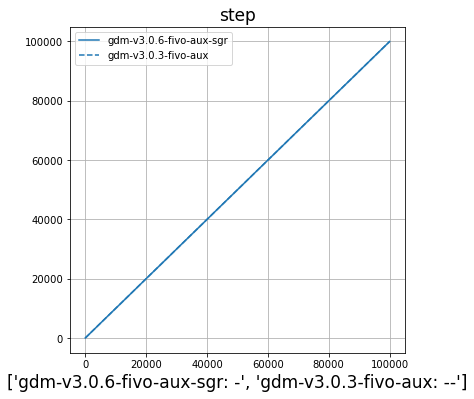

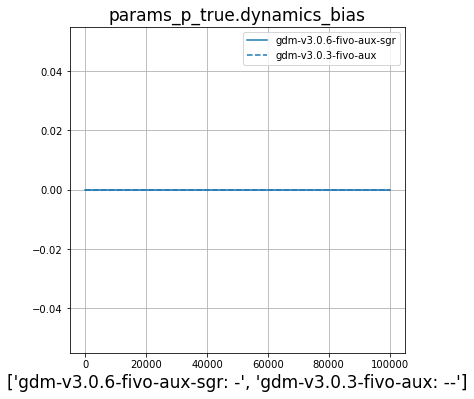

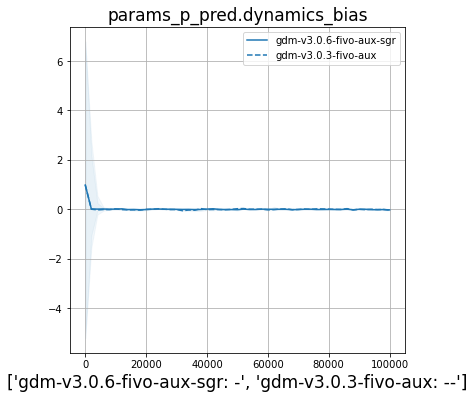

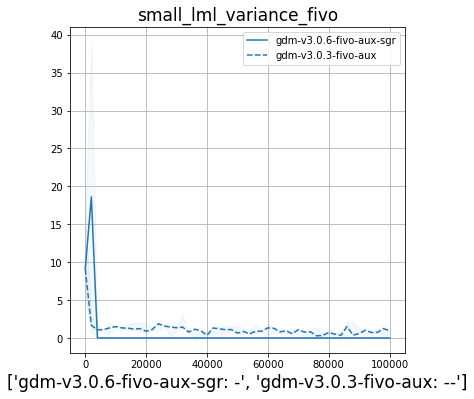

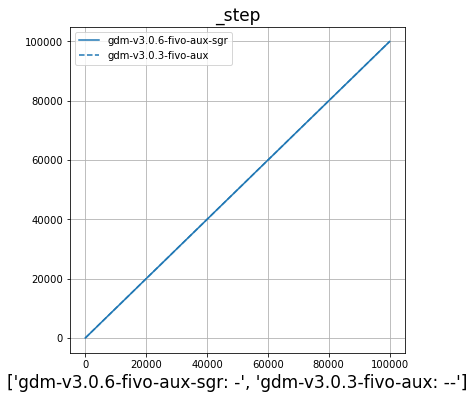

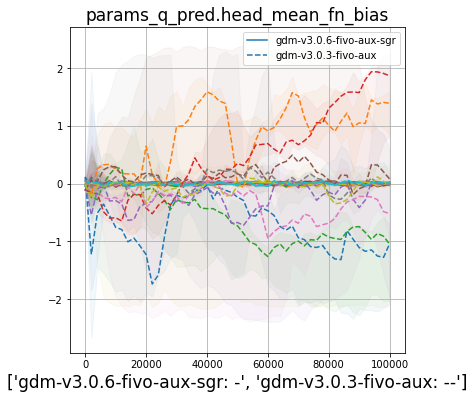

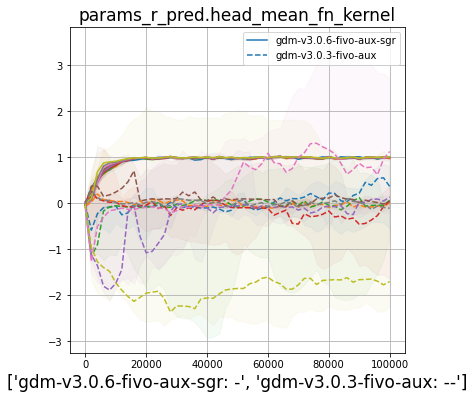

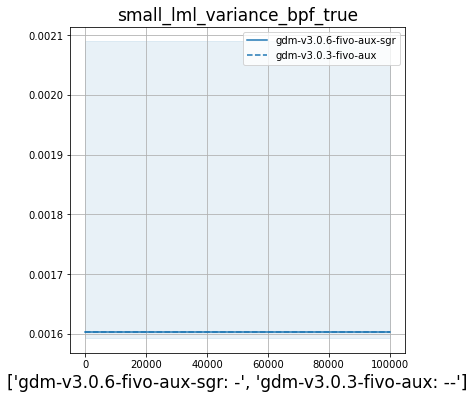

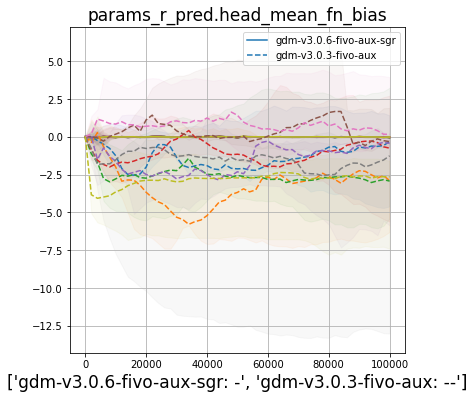

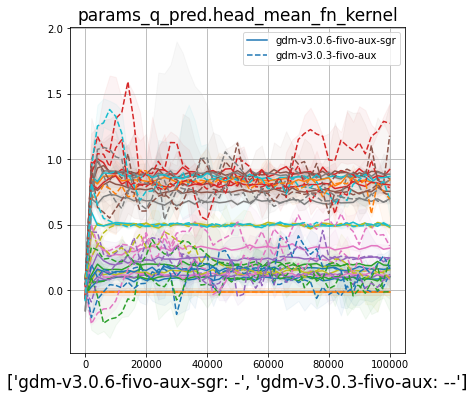

No handles with labels found to put in legend.


Skipping:  small_lml_mean_em_true gdm-v3.0.6-fivo-aux-sgr
Skipping:  small_lml_mean_em_true gdm-v3.0.3-fivo-aux


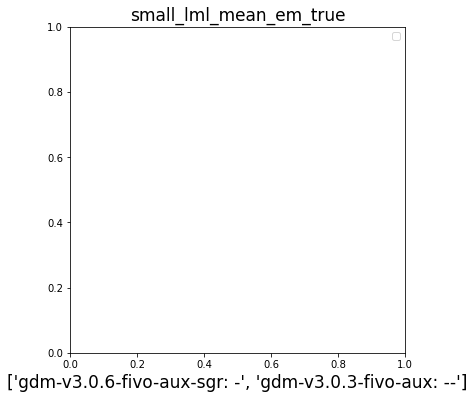

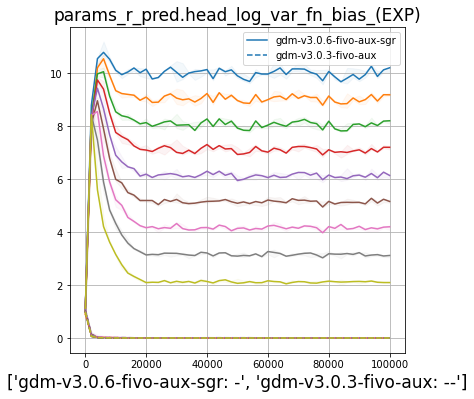

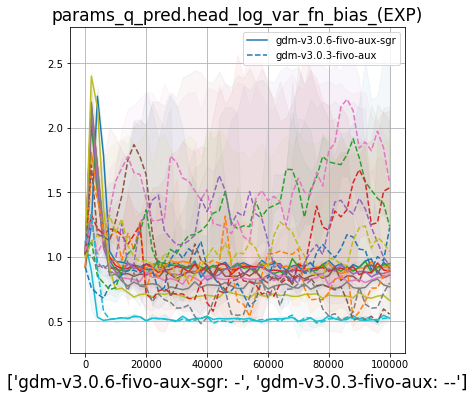

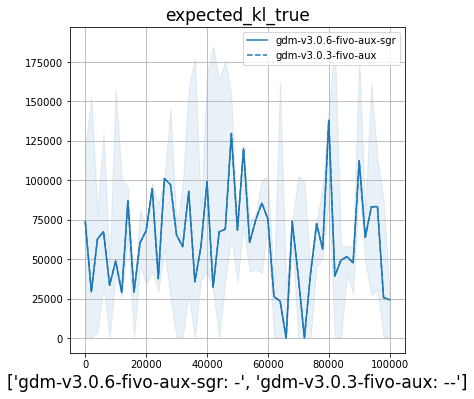

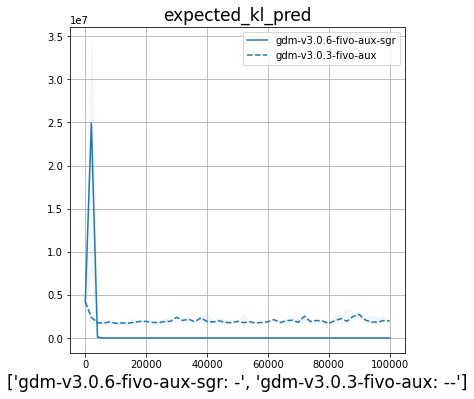

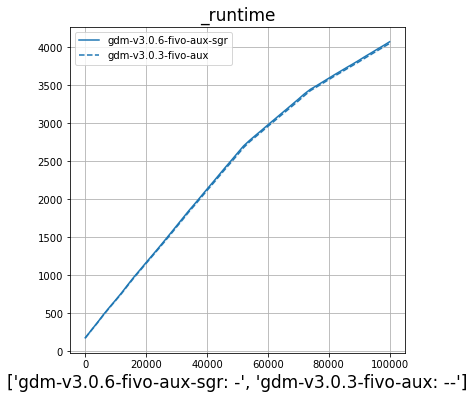

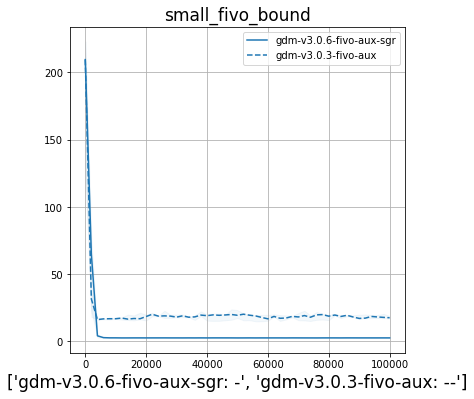

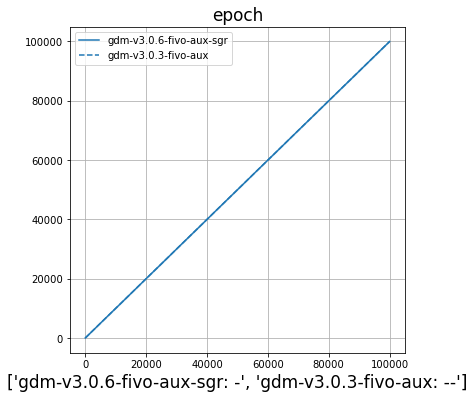

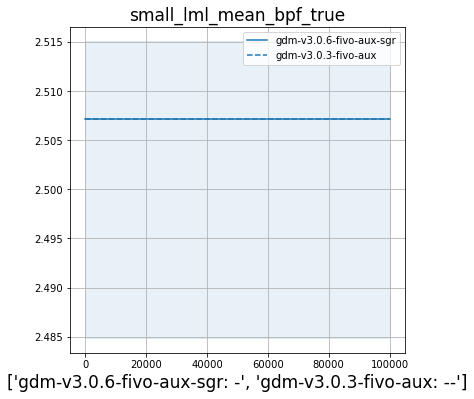

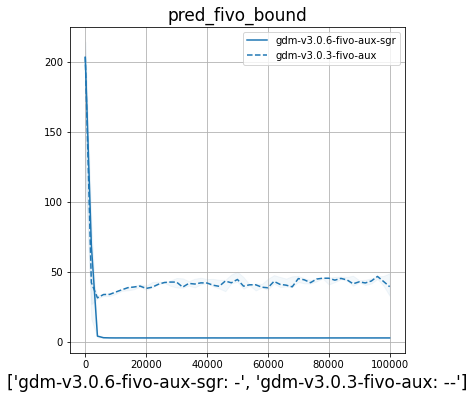

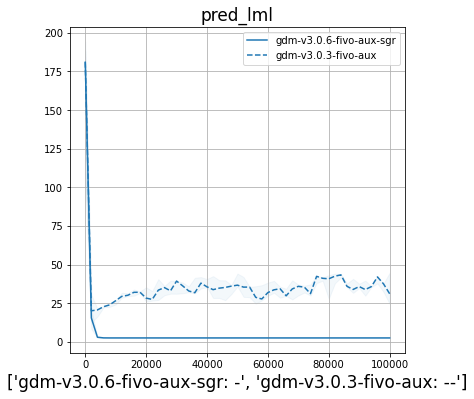

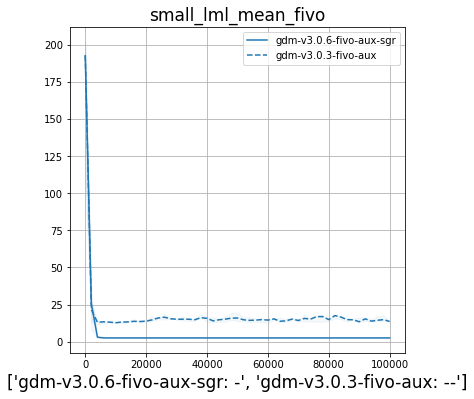

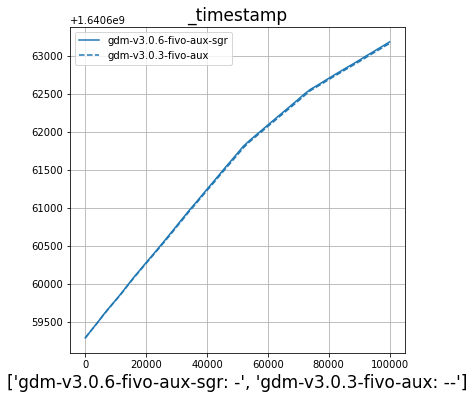

In [5]:
all_keys_to_plot = column_names  # list(filtered_histories[0][0].keys())  # ['params_q_pred.head_mean_fn_kernel',]  # {list(filtered_histories[0][0].keys()), [STR,]}

label_gen = lambda __str, __i=0: __str if __i == 0 else None

for key_to_plot in all_keys_to_plot:

    x = filtered_histories[0][0].get('step').values.squeeze()
    
#     try:

    f = plt.figure(figsize=(6,6))

    for _i, _k in enumerate(exp_tag):

        to_plot = []
        for _j in range(len(filtered_histories[_i])):
            if filtered_histories[_i][_j].get(key_to_plot) is not None:
                if np.asarray(np.stack(filtered_histories[_i][_j].get(key_to_plot).values.squeeze())).flatten()[0] is not None:
                    # print('a', np.asarray(np.stack(filtered_histories[_i][_j].get(key_to_plot).values.squeeze()))[..., 0])
                    to_plot.append(np.stack(filtered_histories[_i][_j].get(key_to_plot).values.squeeze()))
#             else:
#                 print(key_to_plot, filtered_histories[_i][_j].get(key_to_plot))

        if len(to_plot) == 0:
            print('Skipping: ', key_to_plot, _k)
            continue
        
        h = np.stack(to_plot).squeeze()
        mu = np.quantile(h, 0.50, axis=0)
        lq = np.quantile(h, 0.25, axis=0)
        uq = np.quantile(h, 0.75, axis=0)

        mu = mu.reshape(len(mu), -1)
        lq = lq.reshape(len(lq), -1)
        uq = uq.reshape(len(uq), -1)

        for _j in range(len(mu.T)):
            plt.plot(x, mu[:, _j], c=color_names[_j], linestyle=plot_styles[_i], label=label_gen(_k, _j))
            plt.fill_between(x, lq[:, _j], uq[:, _j], color=color_names[_j], alpha=0.05)
        plt.grid(True)

    plt.xlabel(['{}: {}'.format(_a, _b) for _a, _b in zip(exp_tag, plot_styles)], fontsize=17)
    plt.title(key_to_plot, fontsize=17)
    plt.legend()

    plt.savefig('{}/Downloads/{}_{}.pdf'.format(home, save_tag, key_to_plot))
    plt.pause(0.1)

#     except Exception as err:
#         print(key_to_plot, 'failed.')
#         print(err)
#         plt.close(f)
        
#         print(np.stack(filtered_histories[_i][_j].get(key_to_plot).values.squeeze()))
#         print(np.stack(filtered_histories[_i][0].get(key_to_plot).values.squeeze()))
#         print(_j)
        

In [6]:
plt.plot(x, mu[:, _j], c=color_names[_j], linestyle=plot_styles[_i])

TypeError: list indices must be integers or slices, not str

In [ ]:
column_names

In [ ]:
filtered_histories[_i][_j].get(key_to_plot).values[1:]

In [ ]:
filtered_histories[_i][_j].get(key_to_plot).values[1:]

In [ ]:
print(_i)

In [ ]:
list(filtered_histories[0].columns())

In [ ]:
_i = 0
print(np.arange(10)[_i])

In [47]:
api = wandb.Api()
runs = api.runs(project)
ex_idx = np.where(np.asarray([_r.name == 'worldly-dream-1269' for _r in runs]))[0][0]

In [48]:
p = runs[ex_idx].history(samples=99999999)

In [49]:
p.columns

Index(['upc_fivo', 'step', 'params_p_true.dynamics_bias', 'upc_bpf_true',
       'params_p_pred.dynamics_bias', 'expected_upc_fivo',
       'small_lml_variance_fivo', '_step', 'params_q_pred.head_mean_fn_bias',
       'params_r_pred.head_mean_fn_kernel', 'small_lml_variance_bpf_true',
       'params_r_pred.head_mean_fn_bias', 'params_q_pred.head_mean_fn_kernel',
       'small_lml_mean_em_true', 'params_r_pred.head_log_var_fn_bias_(EXP)',
       'params_q_pred.head_log_var_fn_bias_(EXP)', 'expected_kl_true',
       'expected_kl_pred', '_runtime', 'small_fivo_bound', 'epoch',
       'small_lml_mean_bpf_true', 'pred_fivo_bound', 'pred_lml',
       'small_lml_mean_fivo', 'expected_upc_bpf_true', '_timestamp',
       'true_lml'],
      dtype='object')

In [75]:
api = wandb.Api()
runs = api.runs(project)

x1 = []
n_avg = 10
for _str in ['avid-wind-1279']: # ['worldly-dream-1267', 'unique-music-1265', 'kind-water-1266', 'fiery-lion-1269', 'warm-sun-1271']:
    ex_idx = np.where(np.asarray([_r.name == _str for _r in runs]))[0][0]
    p = runs[ex_idx].history(samples=99999999)
    x1.append(np.stack(p.get('params_r_pred.head_log_var_fn_bias_(EXP)').values).squeeze()[-n_avg:].mean(axis=0))
    print('  '.join(['{: >5.3f}'.format(_s) for _s in np.stack(p.get('params_r_pred.head_log_var_fn_bias_(EXP)').values).squeeze()[-n_avg:].mean(axis=0)]))
    
print()

x2 = []
n_avg = 15
for _str in ['worldly-dream-1267', 'unique-music-1265', 'kind-water-1266', 'fiery-lion-1269', 'warm-sun-1271']:
    ex_idx = np.where(np.asarray([_r.name == _str for _r in runs]))[0][0]
    p = runs[ex_idx].history(samples=99999999)
    x2.append(np.stack(p.get('params_r_pred.head_log_var_fn_bias_(EXP)').values).squeeze()[-n_avg:].mean(axis=0))
    print('  '.join(['{: >5.3f}'.format(_s) for _s in np.stack(p.get('params_r_pred.head_log_var_fn_bias_(EXP)').values).squeeze()[-n_avg:].mean(axis=0)]))
    
print('  '.join(['{: >5.3f}'.format(_s) for _s in np.asarray(x1).mean(axis=0)]))
print('  '.join(['{: >5.3f}'.format(_s) for _s in np.asarray(x2).mean(axis=0)]))

10.081  9.172  8.059  7.177  6.164  5.134  4.110  3.067  2.073

10.057  9.042  7.942  7.024  6.042  4.982  3.974  2.957  2.013
9.942  8.919  7.977  6.997  6.040  5.084  4.039  3.054  2.015
9.928  8.952  7.949  6.876  5.920  4.929  4.042  3.053  2.003
9.915  8.958  7.941  6.915  5.901  4.907  3.929  2.952  2.004
10.009  9.058  8.092  7.071  6.071  5.054  4.009  2.970  1.984


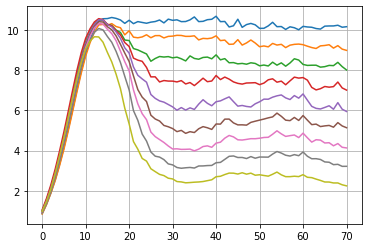

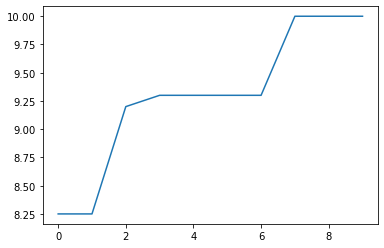

In [142]:
exp_tag = 'peach-cloud-1702'

api = wandb.Api()
runs = api.runs(project)

ex_idx = np.where(np.asarray([_r.name == exp_tag for _r in runs]))[0][0]
p = runs[ex_idx].history(samples=99999999)

plt.plot(np.stack(p.get('params_r_pred.head_log_var_fn_bias_(EXP)').values).squeeze())
plt.grid(True)

plt.figure()
# p.get('upc.variance.bpf_true')
data = p.get('upc.median.fivo')
plt.plot(np.asarray([data[_i] for _i in range(len(data))])[-1])

In [111]:
np.stack(p.get('params_r_pred.head_log_var_fn_bias_(EXP)').values).squeeze()[-5:].mean(axis=0)

array([4.2142827 , 4.14323964, 4.79104004, 4.98393111, 4.68627462,
       4.59876504, 4.5202498 , 4.39576602, 4.70260401])

0    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1    [1, 1, 1, 1, 1, 1, 1, 1, 1, 3]
2    [1, 1, 1, 1, 1, 1, 1, 1, 1, 4]
3    [1, 1, 1, 1, 1, 1, 1, 1, 1, 8]
4    [1, 1, 1, 1, 1, 1, 1, 1, 1, 7]
5    [1, 1, 1, 1, 1, 1, 1, 1, 1, 8]
6    [1, 1, 1, 1, 1, 1, 1, 1, 2, 4]
7    [1, 1, 1, 1, 1, 1, 1, 1, 2, 8]
Name: upc.median.fivo, dtype: object

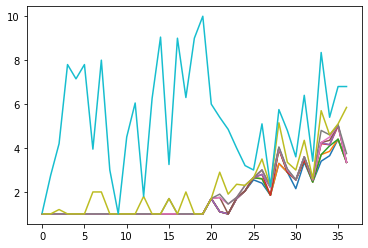

In [145]:
a = np.asarray([1, 2, 3, 4])
np.quantile(a, 0.5)

2.5